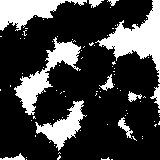

In [3]:
import random
import torch
import torchvision as tv

grid=torch.rand((160, 160))
grid

tensorToImageTransform=tv.transforms.ToPILImage()

def corePhase(grid, prob=0.05):
    return (grid>prob).float()

grid=corePhase(grid, 0.001)

tensorToImageTransform(grid)
def growthPhase(grid, prob, endingWt):
    idxs=torch.nonzero(grid==0)
    if len(idxs)/(grid.shape[0]*grid.shape[1])>endingWt:
        return False
    dirs=[[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    for [i,j] in idxs:
        for [x,y] in dirs:
            if  max(1,(x*y!=0)*4)*random.random()<prob and 0<=i+x<grid.shape[0] and 0<=j+y<grid.shape[1]:
                grid[i+x, j+y]=0
    return True
i=0
while growthPhase(grid, 0.075, 0.75):
    i+=1
display(tensorToImageTransform(grid))

In [12]:
egNodes=len(torch.nonzero(grid==0))
parNodes=len(torch.nonzero(grid==1))
parDensity=914
satEgDensity=807.51
egVolPercent=egNodes/(egNodes+parNodes)
egNodes, parNodes, egVolPercent

(19227, 6373, 0.7510546875)

In [14]:
egWeight=egNodes*satEgDensity
parWeight=parNodes*parDensity
egWeight, parWeight

(15525994.77, 5824922)

In [15]:
egWeightFraction=egWeight/(parWeight+egWeight)
egWeightFraction

0.7271816445753491